# Analisi Esplorativa dei Dati (EDA) e Baseline Model

In questo notebook, ci concentriamo sulla preparazione dei dati e sulla creazione di un modello baseline (Naive Bayes) per confrontare le prestazioni con modelli più complessi (LSTM, BERT).

## Obiettivi:
1. **Raggruppamento delle Classi**: Semplificare il problema unendo disturbi simili.
   - `Bipolar` + `Personality disorder` -> **`Serious`**
   - `Anxiety` + `Stress` -> **`Light`**
2. **Bilanciamento del Dataset**: Sottocampionare le classi maggioritarie (`Normal`, `Depression`, `Suicidal`) per evitare bias verso le classi più frequenti.
3. **Visualizzazione (EDA)**: Analizzare la distribuzione delle classi e la lunghezza dei testi.
4. **Baseline Model**: Addestrare un classificatore Naive Bayes (TF-IDF) come punto di riferimento.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import resample

# Configurazione grafici
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## 1. Caricamento e Mappatura dei Dati

/var/folders/5_/mnr70g2511s9w_v5w224k2x00000gn/T/ipykernel_11408/2887332370.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='status', data=df, palette='viridis', order=df['status'].value_counts().index)


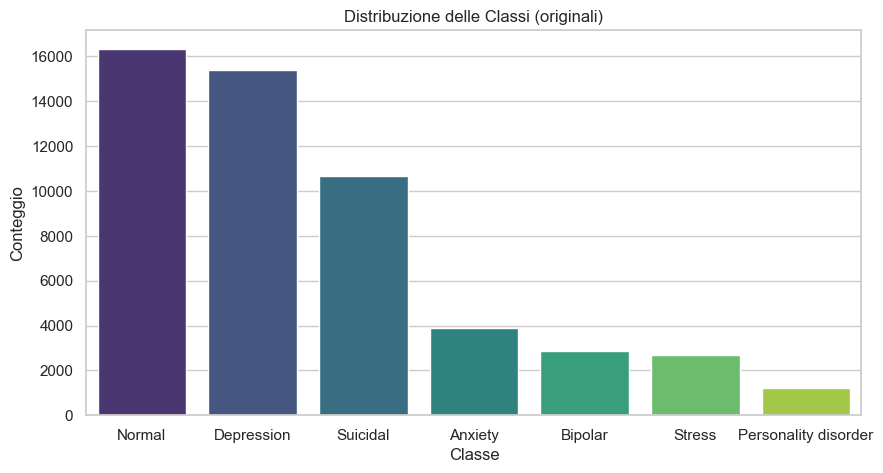

Distribuzione Originale:
status
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64
Nuova Distribuzione (Post-Mapping):
target
Normal        16351
Depression    15404
Serious       14731
Light          6557
Name: count, dtype: int64


In [7]:
# Caricamento dataset
df = pd.read_csv('../data/processed/mental.csv')

# Grafico Distribuzione Classi
plt.figure(figsize=(10, 5))
sns.countplot(x='status', data=df, palette='viridis', order=df['status'].value_counts().index)
plt.title('Distribuzione delle Classi (originali)')
plt.xlabel('Classe')
plt.ylabel('Conteggio')
plt.show()

# Visualizza distribuzione originale
print("Distribuzione Originale:")
print(df['status'].value_counts())

# Funzione di Mappatura
def map_labels(label):
    if label in ['Bipolar', 'Personality disorder', 'Suicidal']:
        return 'Serious'
    elif label in ['Anxiety', 'Stress']:
        return 'Light'
    else:
        return label

df['target'] = df['status'].apply(map_labels)

print("Nuova Distribuzione (Post-Mapping):")
print(df['target'].value_counts())

## 2. Bilanciamento delle Classi
Le classi `Normal`, `Depression` e `Suicidal` sono molto numerose rispetto alle nuove classi `Serious` e `Light`.
Procediamo con un undersampling controllato (target ~7000 campioni per le classi maggioritarie) per rendere il training più equilibrato senza perdere troppe informazioni.

In [8]:
def balance_classes(df, target_column='target', max_samples=7000):
    balanced_dfs = []
    
    # Calcola la dimensione minima o usa un tetto massimo
    # In questo caso usiamo un valore fisso 'max_samples' per le classi maggioritarie
    
    for label in df[target_column].unique():
        df_class = df[df[target_column] == label]
        
        if len(df_class) > max_samples:
            df_class = resample(df_class, 
                                replace=False, 
                                n_samples=max_samples, 
                                random_state=42)
        
        balanced_dfs.append(df_class)
    
    return pd.concat(balanced_dfs).reset_index(drop=True)

df_balanced = balance_classes(df, max_samples=8000)

print("Distribuzione Bilanciata:")
print(df_balanced['target'].value_counts())

Distribuzione Bilanciata:
target
Normal        8000
Depression    8000
Serious       8000
Light         6557
Name: count, dtype: int64


In [9]:

# Salva il dataset bilanciato per uso in altri notebook
output_path = '../data/processed/mental_balanced.csv'
df_balanced.to_csv(output_path, index=False)
print(f"Dataset bilanciato salvato in: {output_path}")


Dataset bilanciato salvato in: ../data/processed/mental_balanced.csv


## 3. Visualizzazione (EDA)

/var/folders/5_/mnr70g2511s9w_v5w224k2x00000gn/T/ipykernel_11408/381790441.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target', data=df_balanced, palette='viridis', order=df_balanced['target'].value_counts().index)


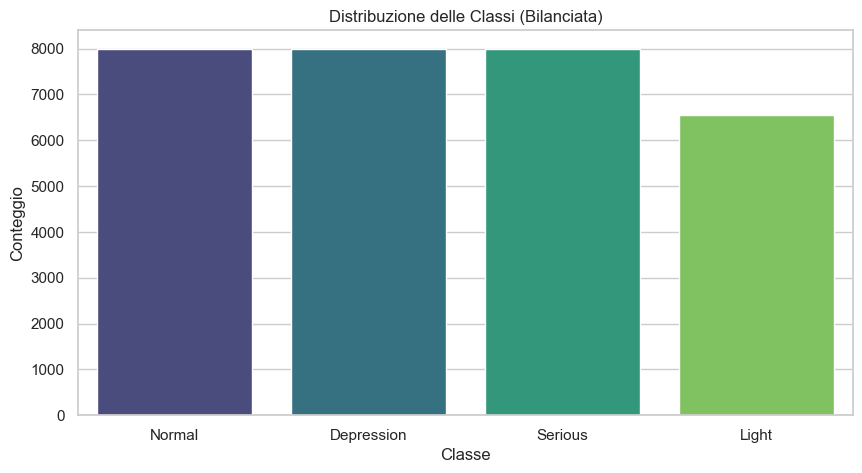

/var/folders/5_/mnr70g2511s9w_v5w224k2x00000gn/T/ipykernel_11408/381790441.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='target', y='word_count', data=df_balanced, palette='pastel')


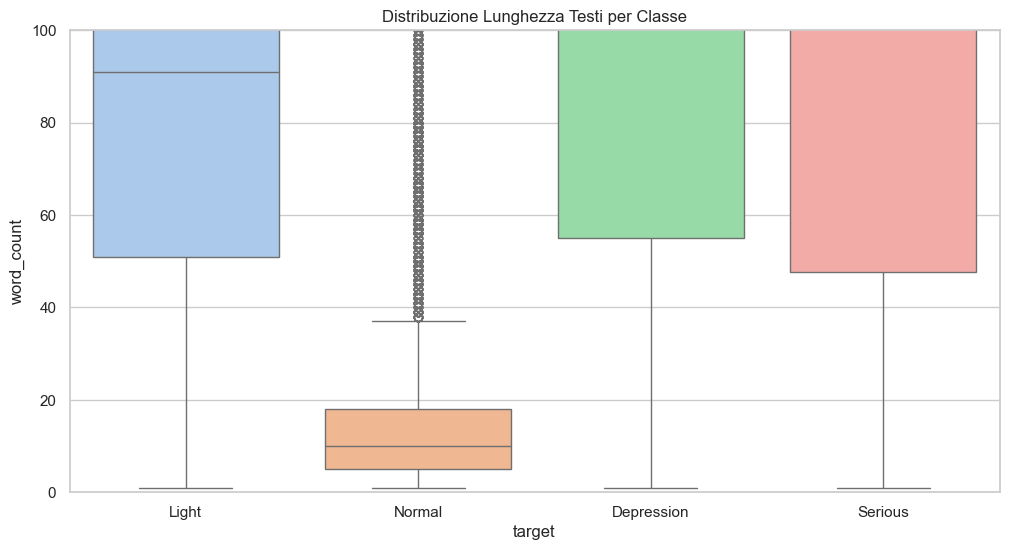

In [10]:
# Grafico Distribuzione Classi
plt.figure(figsize=(10, 5))
sns.countplot(x='target', data=df_balanced, palette='viridis', order=df_balanced['target'].value_counts().index)
plt.title('Distribuzione delle Classi (Bilanciata)')
plt.xlabel('Classe')
plt.ylabel('Conteggio')
plt.show()

# Analisi Lunghezza Testi
df_balanced['word_count'] = df_balanced['statement'].astype(str).apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 6))
sns.boxplot(x='target', y='word_count', data=df_balanced, palette='pastel')
plt.title('Distribuzione Lunghezza Testi per Classe')
plt.ylim(0, 100) # Limitiamo l'asse Y per leggibilità
plt.show()

## 4. Baseline Model: Naive Bayes
Utilizziamo una pipeline `TF-IDF` + `MultinomialNB`.

In [6]:
# Split Train/Test
X = df_balanced['statement'].astype(str)
y = df_balanced['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Pipeline
model_nb = make_pipeline(
    TfidfVectorizer(max_features=5000, stop_words='english'),
    MultinomialNB()
)

# Addestramento
print("Addestramento Naive Bayes...")
model_nb.fit(X_train, y_train)

# Predizione
y_pred = model_nb.predict(X_test)

# Metriche
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Addestramento Naive Bayes...
Accuracy: 0.662630890052356
Classification Report:
              precision    recall  f1-score   support

  Depression       0.53      0.67      0.59      1600
       Light       0.79      0.67      0.73      1312
      Normal       0.84      0.66      0.74      1600
     Serious       0.61      0.64      0.63      1600

    accuracy                           0.66      6112
   macro avg       0.69      0.66      0.67      6112
weighted avg       0.69      0.66      0.67      6112



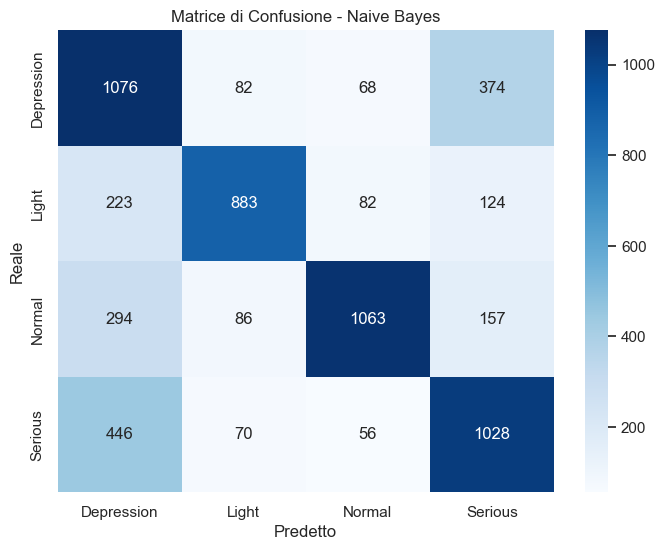

In [7]:
# Matrice di Confusione
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred, labels=model_nb.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model_nb.classes_, yticklabels=model_nb.classes_)
plt.title('Matrice di Confusione - Naive Bayes')
plt.xlabel('Predetto')
plt.ylabel('Reale')
plt.show()